# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract

In [2]:
import tarfile
import os

TAR_PATH = "/content/drive/MyDrive/unique_uis.tar.gz"
EXTRACT_PATH = "/content/uiux_data"

os.makedirs(EXTRACT_PATH, exist_ok=True)

with tarfile.open(TAR_PATH, "r:gz") as tar:
    tar.extractall(path=EXTRACT_PATH)

print("Dataset extracted successfully")

/tmp/ipython-input-2380230178.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=EXTRACT_PATH)


Dataset extracted successfully


# Verify Extraction

In [3]:
os.listdir(EXTRACT_PATH)

['combined']

In [4]:
for root, dirs, files in os.walk("/content/uiux_data/combined/"):
    if any(f.endswith(".png") for f in files):
        print("FOUND PNGs IN:", root)
        break


# Preview Random UI Screenshot

Total UI images found: 66261


(np.float64(-0.5), np.float64(539.5), np.float64(959.5), np.float64(-0.5))

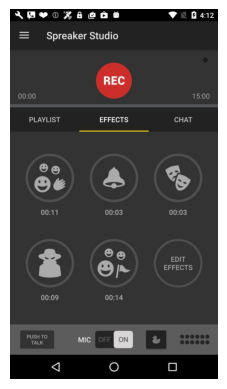

In [5]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

SCREENSHOT_DIR = "/content/uiux_data/combined"
IMAGE_EXTS = (".jpg", ".jpeg", ".png")

images = [
    f for f in os.listdir(SCREENSHOT_DIR)
    if f.lower().endswith(IMAGE_EXTS)
]

print("Total UI images found:", len(images))

img_name = random.choice(images)
img_path = os.path.join(SCREENSHOT_DIR, img_name)

img = Image.open(img_path)
plt.imshow(img)
plt.axis("off")


# Create Project Folder Structure

In [6]:
BASE_DIR = "/content/uiux_project"

dirs = [
    "data/images/clean",
    "data/images/degraded_alignment",
    "data/images/degraded_spacing",
    "data/images/degraded_both"
]

for d in dirs:
    os.makedirs(os.path.join(BASE_DIR, d), exist_ok=True)

print("Project structure created")


Project structure created


# Prepare CLEAN UI Images

In [7]:
import shutil
import random
import os

BASE_DIR = "/content/uiux_project"
DST_CLEAN_DIR = f"{BASE_DIR}/data/images/clean"

os.makedirs(DST_CLEAN_DIR, exist_ok=True)

all_images = [
    f for f in os.listdir(SCREENSHOT_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

sample_images = random.sample(all_images, 500)  # start with 500

for img in sample_images:
    shutil.copy(
        os.path.join(SCREENSHOT_DIR, img),
        os.path.join(DST_CLEAN_DIR, img)
    )

print(f"Copied {len(sample_images)} clean UI images")


Copied 500 clean UI images


# Create Initial labels.csv

In [11]:
import pandas as pd

label_rows = []

for img in os.listdir(DST_CLEAN_DIR):
    label_rows.append({
        "image": img,
        "ux_score": 90,
        "alignment_issue": 0,
        "spacing_issue": 0
    })

labels_df = pd.DataFrame(label_rows)
labels_path = f"{BASE_DIR}/data/labels.csv"
labels_df.to_csv(labels_path, index=False)

labels_df.head()

labels_df.tail()

,image,ux_score,alignment_issue,spacing_issue
495,37044.jpg,90,0,0
496,56676.jpg,90,0,0
497,69557.jpg,90,0,0
498,42281.jpg,90,0,0
499,16720.jpg,90,0,0


# Dataset Loader

In [12]:
import tensorflow as tf

IMAGE_SIZE = 256
UX_SCORE_SCALE = 100.0

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img


def make_dataset(df, image_root, batch_size=16, shuffle=True):
    image_paths = df["image"].apply(
        lambda x: os.path.join(image_root, x)
    ).values

    ux_scores = df["ux_score"].values / UX_SCORE_SCALE
    ux_flags = df[["alignment_issue", "spacing_issue"]].values

    ds = tf.data.Dataset.from_tensor_slices(
        (image_paths, (ux_scores, ux_flags))
    )

    def _map_fn(path, labels):
        img = preprocess_image(path)
        return img, labels

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(len(df))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


# Test Data Pipeline

In [13]:
labels = pd.read_csv(labels_path)

train_ds = make_dataset(
    labels,
    image_root=DST_CLEAN_DIR,
    batch_size=8
)

for images, (scores, flags) in train_ds.take(1):
    print("Images shape:", images.shape)
    print("UX scores shape:", scores.shape)
    print("UX flags shape:", flags.shape)


Images shape: (8, 256, 256, 3)
UX scores shape: (8,)
UX flags shape: (8, 2)


# Custom CNN Architecture

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_uiux_cnn(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # ----- Block 1 -----
    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D()(x)  # 128×128

    # ----- Block 2 -----
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D()(x)  # 64×64

    # ----- Block 3 -----
    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D()(x)  # 32×32

    # ----- Block 4 -----
    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ----- Global Features -----
    x = layers.GlobalAveragePooling2D()(x)

    # ----- UX Score Head (Regression) -----
    ux_score = layers.Dense(1, name="ux_score")(x)

    # ----- UX Issue Head (Multi-label) -----
    ux_flags = layers.Dense(2, activation="sigmoid", name="ux_flags")(x)

    model = models.Model(inputs, outputs=[ux_score, ux_flags])
    return model


# Build & Inspect the Model

In [15]:
model = build_uiux_cnn()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 1,176,867 (4.49 MB)

 Trainable params: 1,174,947 (4.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Compile the Model

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "ux_score": "mse",
        "ux_flags": "binary_crossentropy"
    },
    loss_weights={
        "ux_score": 1.0,
        "ux_flags": 1.0
    },
    metrics={
        "ux_score": "mae",
        "ux_flags": "accuracy"
    }
)


# Train the Model (INITIAL TRAINING)

In [17]:
history = model.fit(
    train_ds,
    epochs=10
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 391s 6s/step - loss: 0.6533 - ux_flags_accuracy: 0.2169 - ux_flags_loss: 0.2942 - ux_score_loss: 0.3591 - ux_score_mae: 0.3611
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 432s 6s/step - loss: 0.0179 - ux_flags_accuracy: 0.2366 - ux_flags_loss: 0.0162 - ux_score_loss: 0.0017 - ux_score_mae: 0.0322
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 405s 6s/step - loss: 0.0086 - ux_flags_accuracy: 0.1877 - ux_flags_loss: 0.0071 - ux_score_loss: 0.0015 - ux_score_mae: 0.0296
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - loss: 0.0049 - ux_flags_accuracy: 0.2035 - ux_flags_loss: 0.0040 - ux_score_loss: 8.5572e-04 - ux_score_mae: 0.0231
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 428s 6s/step - loss: 0.0032 - ux_flags_accuracy: 0.1436 - ux_flags_loss: 0.0026 - ux_score_loss: 5.2653e-04 - ux_score_mae: 0.0178
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - loss: 0.0025 - ux_flags_accuracy: 0.1273 - ux_flags_loss: 0.0019 - ux_score_loss: 6.6697e-04 - ux_score_mae: 0.020

# Plot Training Curves

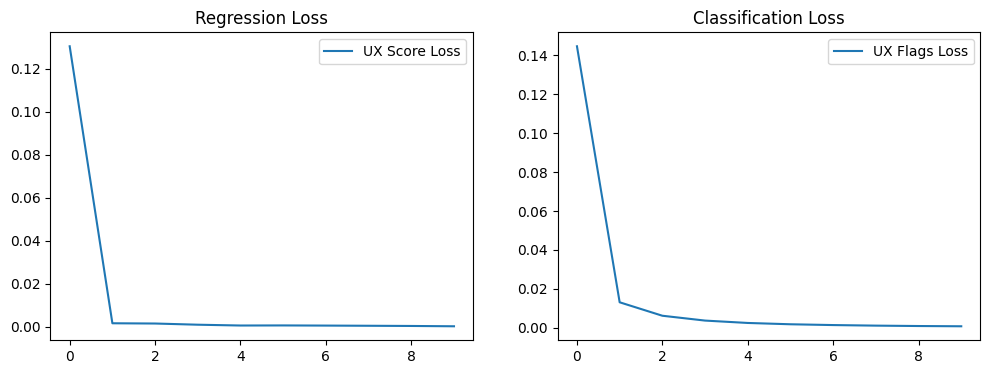

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# UX Score Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["ux_score_loss"], label="UX Score Loss")
plt.legend()
plt.title("Regression Loss")

# UX Flags Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["ux_flags_loss"], label="UX Flags Loss")
plt.legend()
plt.title("Classification Loss")

plt.show()


# Test a Single Prediction

In [19]:
import numpy as np

sample_batch = next(iter(train_ds))
images, (scores, flags) = sample_batch

pred_score, pred_flags = model.predict(images[:1])

print("Predicted UX score:", float(pred_score[0]) * 100)
print("Predicted UX flags:", pred_flags[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
Predicted UX score: 86.79913878440857
Predicted UX flags: [0.00089737 0.00122866]


/tmp/ipython-input-3127732282.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted UX score:", float(pred_score[0]) * 100)


# Import Utilities for Image Manipulation

In [20]:
import cv2
import numpy as np
import os
import random
import pandas as pd


# Define Synthetic Degradation Functions

In [21]:
def degrade_alignment(img, max_shift=20):
    h, w, _ = img.shape
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)

    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted = cv2.warpAffine(
        img, M, (w, h),
        borderMode=cv2.BORDER_REFLECT
    )
    return shifted


# Spacing Degradation (Local Cropping & Resize)

In [22]:
def degrade_spacing(img, crop_ratio=0.9):
    h, w, _ = img.shape
    ch, cw = int(h * crop_ratio), int(w * crop_ratio)

    start_y = random.randint(0, h - ch)
    start_x = random.randint(0, w - cw)

    cropped = img[start_y:start_y+ch, start_x:start_x+cw]
    resized = cv2.resize(cropped, (w, h))
    return resized


# Combined Degradation

In [23]:
def degrade_both(img):
    img = degrade_alignment(img)
    img = degrade_spacing(img)
    return img


# Generate Degraded Dataset

In [24]:
CLEAN_DIR = f"{BASE_DIR}/data/images/clean"
ALIGN_DIR = f"{BASE_DIR}/data/images/degraded_alignment"
SPACE_DIR = f"{BASE_DIR}/data/images/degraded_spacing"
BOTH_DIR  = f"{BASE_DIR}/data/images/degraded_both"

os.makedirs(ALIGN_DIR, exist_ok=True)
os.makedirs(SPACE_DIR, exist_ok=True)
os.makedirs(BOTH_DIR, exist_ok=True)


In [25]:
import os
new_labels = []

clean_images = os.listdir(CLEAN_DIR)

for img_name in clean_images:
    img_path = os.path.join(CLEAN_DIR, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    # Alignment degradation
    img_align = degrade_alignment(img)
    cv2.imwrite(os.path.join(ALIGN_DIR, img_name), img_align)
    new_labels.append([img_name, 65, 1, 0])

    # Spacing degradation
    img_space = degrade_spacing(img)
    cv2.imwrite(os.path.join(SPACE_DIR, img_name), img_space)
    new_labels.append([img_name, 65, 0, 1])

    # Combined degradation
    img_both = degrade_both(img)
    cv2.imwrite(os.path.join(BOTH_DIR, img_name), img_both)
    new_labels.append([img_name, 40, 1, 1])


In [26]:
labels_df = pd.read_csv(labels_path)

degraded_df = pd.DataFrame(
    new_labels,
    columns=["image", "ux_score", "alignment_issue", "spacing_issue"]
)

labels_df = pd.concat([labels_df, degraded_df], ignore_index=True)
labels_df.to_csv(labels_path, index=False)

print("Updated labels:", labels_df.shape)
labels_df.head()


Updated labels: (2000, 4)


,image,ux_score,alignment_issue,spacing_issue
0,7283.jpg,90,0,0
1,62404.jpg,90,0,0
2,33349.jpg,90,0,0
3,44640.jpg,90,0,0
4,40453.jpg,90,0,0


# Build Full Training Dataset

In [27]:
def make_full_dataset(labels_df, batch_size=16):
    image_paths = []
    for _, row in labels_df.iterrows():
        if row["alignment_issue"] and row["spacing_issue"]:
            folder = BOTH_DIR
        elif row["alignment_issue"]:
            folder = ALIGN_DIR
        elif row["spacing_issue"]:
            folder = SPACE_DIR
        else:
            folder = CLEAN_DIR

        image_paths.append(os.path.join(folder, row["image"]))

    ux_scores = labels_df["ux_score"].values / UX_SCORE_SCALE
    ux_flags = labels_df[["alignment_issue", "spacing_issue"]].values

    ds = tf.data.Dataset.from_tensor_slices(
        (image_paths, (ux_scores, ux_flags))
    )

    def _map_fn(path, labels):
        img = preprocess_image(path)
        return img, labels

    ds = ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(len(labels_df)).batch(16).prefetch(tf.data.AUTOTUNE)
    return ds


In [28]:
full_ds = make_full_dataset(labels_df)

# Define Checkpoint + Early Stop

In [30]:
import tensorflow as tf

checkpoint_path = "/content/drive/MyDrive/uiux_checkpoint.keras"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Checkpointing enabled. Model will be saved safely.")


Checkpointing enabled. Model will be saved safely.


# Reduce Compute Load NOW

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "ux_score": "mse",
        "ux_flags": "binary_crossentropy"
    },
    loss_weights={
        "ux_score": 1.0,
        "ux_flags": 1.0
    },
    metrics={
        "ux_score": "mae",
        "ux_flags": "accuracy"
    }
)

print("Model recompiled successfully after freezing layers.")


Model recompiled successfully after freezing layers.


# REAL TRAINING

In [33]:
history = model.fit(
    full_ds,
    epochs=10,   # run in SAFE BLOCKS
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - loss: 0.6015 - ux_flags_accuracy: 0.6538 - ux_flags_loss: 0.5791 - ux_score_loss: 0.0225 - ux_score_mae: 0.1277
Epoch 1: loss improved from inf to 0.58930, saving model to /content/drive/MyDrive/uiux_checkpoint.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1087s 9s/step - loss: 0.6014 - ux_flags_accuracy: 0.6539 - ux_flags_loss: 0.5790 - ux_score_loss: 0.0225 - ux_score_mae: 0.1277
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.5497 - ux_flags_accuracy: 0.7109 - ux_flags_loss: 0.5316 - ux_score_loss: 0.0181 - ux_score_mae: 0.1127
Epoch 2: loss improved from 0.58930 to 0.55042, saving model to /content/drive/MyDrive/uiux_checkpoint.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1070s 8s/step - loss: 0.5497 - ux_flags_accuracy: 0.7108 - ux_flags_loss: 0.5316 - ux_score_loss: 0.0181 - ux_score_mae: 0.1128
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.5274 - ux_flags_accuracy: 0.7032 - ux_flags_loss: 0.5094 - ux_score_loss: 0.0179 

# Analyze Learning Curves

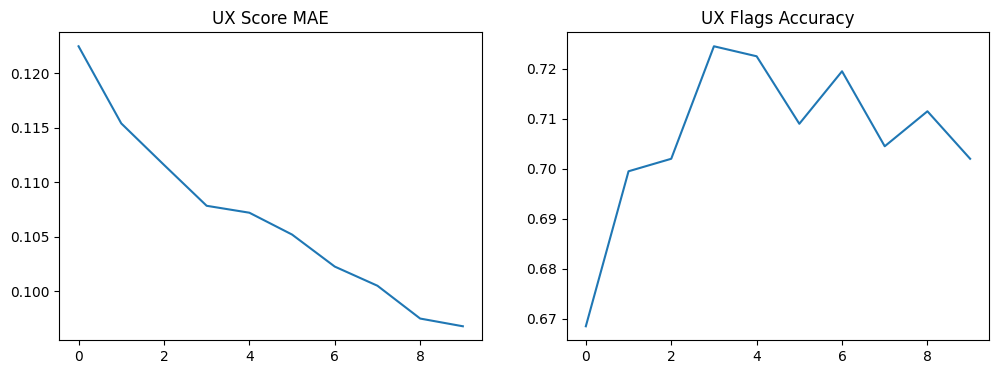

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["ux_score_mae"])
plt.title("UX Score MAE")

plt.subplot(1, 2, 2)
plt.plot(history.history["ux_flags_accuracy"])
plt.title("UX Flags Accuracy")

plt.show()

# Sanity Test (Good vs Bad UI)

In [35]:
sample_clean = random.choice(os.listdir(CLEAN_DIR))
sample_bad = random.choice(os.listdir(BOTH_DIR))

def predict_ui(path):
    img = preprocess_image(path)
    img = tf.expand_dims(img, 0)
    score, flags = model.predict(img)
    return score[0][0] * 100, flags[0]

print("GOOD UI:", predict_ui(os.path.join(CLEAN_DIR, sample_clean)))
print("BAD UI:", predict_ui(os.path.join(BOTH_DIR, sample_bad)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
GOOD UI: (np.float32(74.75177), array([0.10366374, 0.13855729], dtype=float32))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
BAD UI: (np.float32(46.432133), array([0.2453014, 0.8461579], dtype=float32))


# Identify the Last Convolution Layer

In [ ]:
model.summary()

# Grad-CAM Function (CORE LOGIC)

In [36]:
import tensorflow as tf
import numpy as np
import cv2

def compute_gradcam(model, image, layer_name, output_index=0):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.outputs]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[output_index]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()


# Overlay Heatmap on UI Image

In [37]:
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))

    heatmap = cv2.resize(heatmap, (256, 256))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return img, overlay


# Run Grad-CAM on GOOD vs BAD UI

In [43]:
import random
import matplotlib.pyplot as plt

def explain_ui(image_path, title):
    img = preprocess_image(image_path)
    img_tensor = tf.expand_dims(img, 0)

    score, flags = model.predict(img_tensor)

    heatmap = compute_gradcam(
        model,
        img_tensor,
        LAST_CONV_LAYER,
        output_index=0  # UX score head
    )

    original, overlay = overlay_heatmap(image_path, heatmap)

    print(f"{title}")
    print(f"UX Score: {score[0][0] * 100:.2f}")
    print(f"Flags (alignment, spacing): {flags[0]}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original UI")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Explanation")
    plt.axis("off")
    plt.show()


# Explain a CLEAN UI

In [42]:
good_ui = random.choice(os.listdir(CLEAN_DIR))
explain_ui(os.path.join(CLEAN_DIR, good_ui), "GOOD UI")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


TypeError: compute_gradcam() missing 1 required positional argument: 'layer_name'

# Explain a DEGRADED UI

In [44]:
bad_ui = random.choice(os.listdir(BOTH_DIR))
explain_ui(os.path.join(BOTH_DIR, bad_ui), "BAD UI (Alignment + Spacing Issues)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


NameError: name 'LAST_CONV_LAYER' is not defined

# Save final model

In [45]:
model.save("/content/drive/MyDrive/uiux_final_model.keras")
print("Final model saved successfully.")

Final model saved successfully.


In [46]:
from google.colab import files
files.download("/content/drive/MyDrive/uiux_final_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>